In [1]:
from IPython.display import clear_output

!pip install torchvision==0.6.1
clear_output()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


DATA_PATH = '/root/userspace/public/day1/homework1/data/'

train = pd.read_csv(DATA_PATH + 'train.csv')
train = train.fillna(train.median()).values
x_train = train[:, :-1]
t_train = train[:, -1]

x_test = pd.read_csv(DATA_PATH + 'test.csv')
x_test = x_test.fillna(x_test.median()).values

x_train, x_valid, t_train, t_valid = \
    train_test_split(x_train, t_train, test_size=0.2, random_state=42)


scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)


class TrainDataset(torch.utils.data.Dataset):
    
    def __init__(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train
        
    def __len__(self):
        return len(self.x_train)
        
    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), \
            torch.tensor(self.t_train[idx], dtype=torch.float)

    
class TestDataset(torch.utils.data.Dataset):
    
    def __init__(self, x_test):
        self.x_test = x_test
        
    def __len__(self):
        return len(self.x_test)
        
    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)


train_dataset = TrainDataset(x_train, t_train)
valid_dataset = TrainDataset(x_valid, t_valid)
test_dataset = TestDataset(x_test)

## ニューラルネットによる赤ワイン品質の回帰

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Understand data 
wine = pd.read_csv('/root/userspace/public/day1/homework1/data/train.csv')
wine = wine.fillna(wine.median())

print ('\nFeature data, shape:\nX: {}'.format(wine.shape))


Feature data, shape:
X: (1280, 12)


In [13]:
print(wine.isnull().sum()) 

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [14]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1280.00000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,8.34125,0.527187,0.271383,2.549766,0.087614,15.599844,45.652812,0.997051,3.309469,0.658953,10.427813,5.614297
std,1.74115,0.181153,0.194353,1.452651,0.049233,10.482150,32.914044,0.009761,0.149534,0.175200,1.065322,0.987628
min,4.70000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.951600,2.720000,0.330000,8.400000,2.500000
25%,7.10000,0.390000,0.100000,1.900000,0.070000,7.000000,21.675000,0.991000,3.220000,0.550000,9.500000,4.900000
50%,8.00000,0.520000,0.260000,2.200000,0.079000,13.100000,36.800000,0.997350,3.310000,0.620000,10.200000,5.500000
75%,9.30000,0.640000,0.430000,2.600000,0.090250,20.925000,60.350000,1.002600,3.390000,0.730000,11.100000,6.300000
max,15.90000,1.610000,1.000000,15.500000,0.615000,71.800000,290.300000,1.029000,3.970000,2.050000,15.000000,9.700000


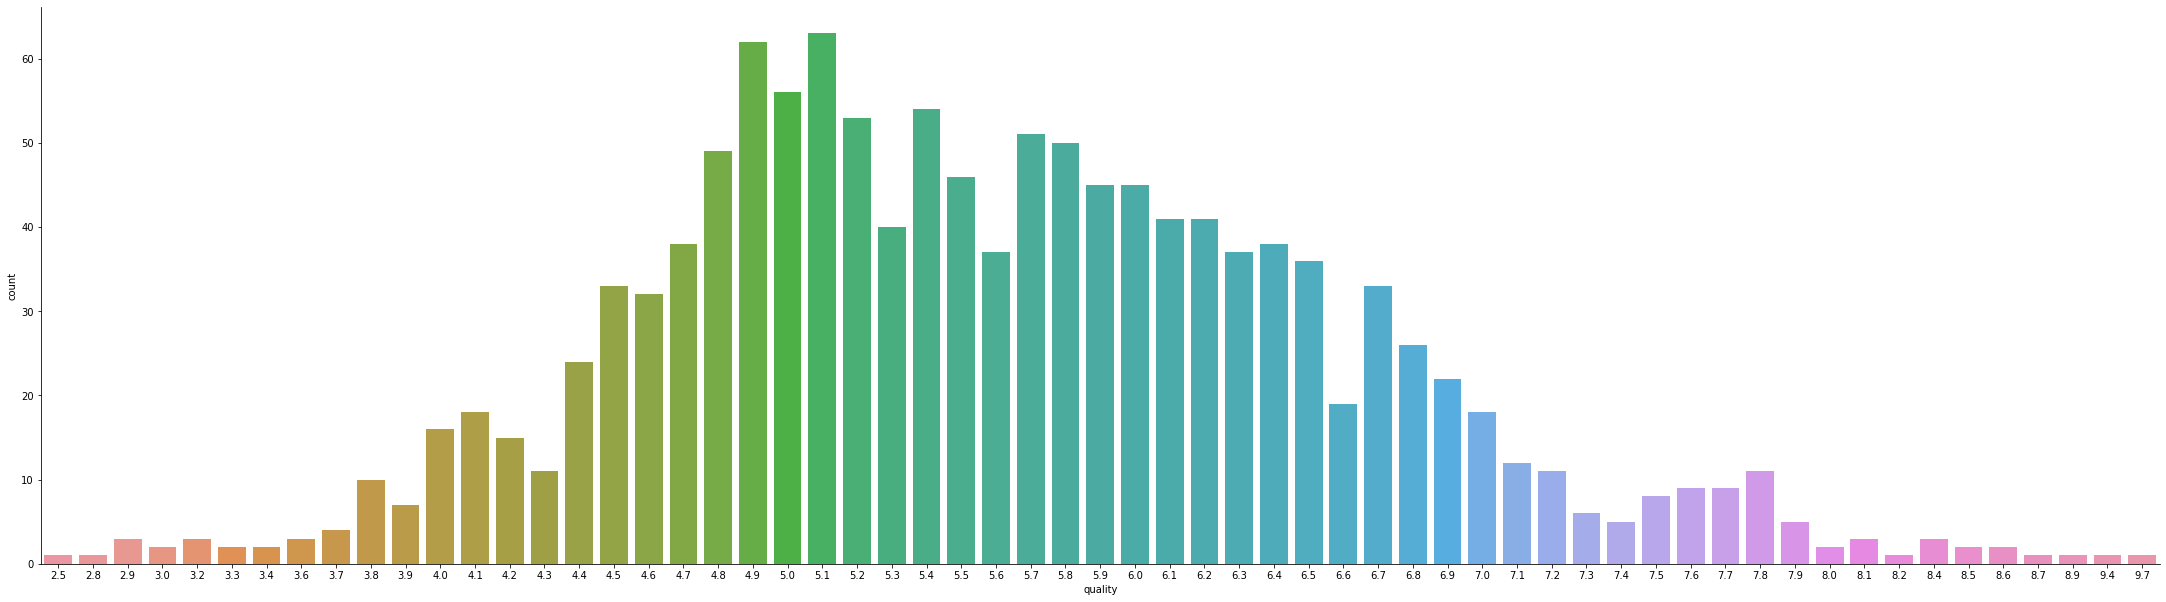

In [15]:
sns.catplot(x='quality', data = wine , kind ='count',height=8.27, aspect=30/8.27)

<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

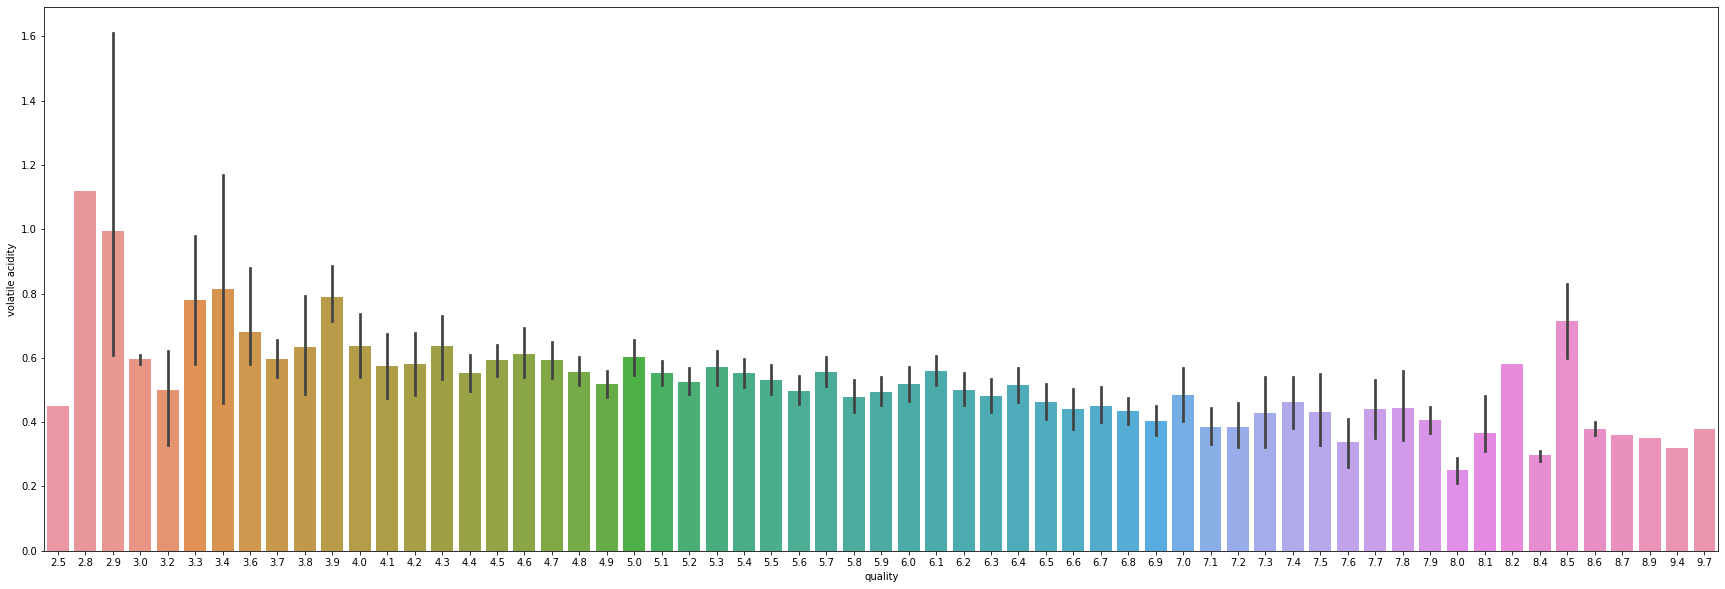

In [16]:
# compare volcatile acidity and quality try to find relationship
plot = plt.figure(figsize=(30,10))
sns.barplot(x='quality', y ='volatile acidity', data = wine)

<AxesSubplot:xlabel='quality', ylabel='citric acid'>

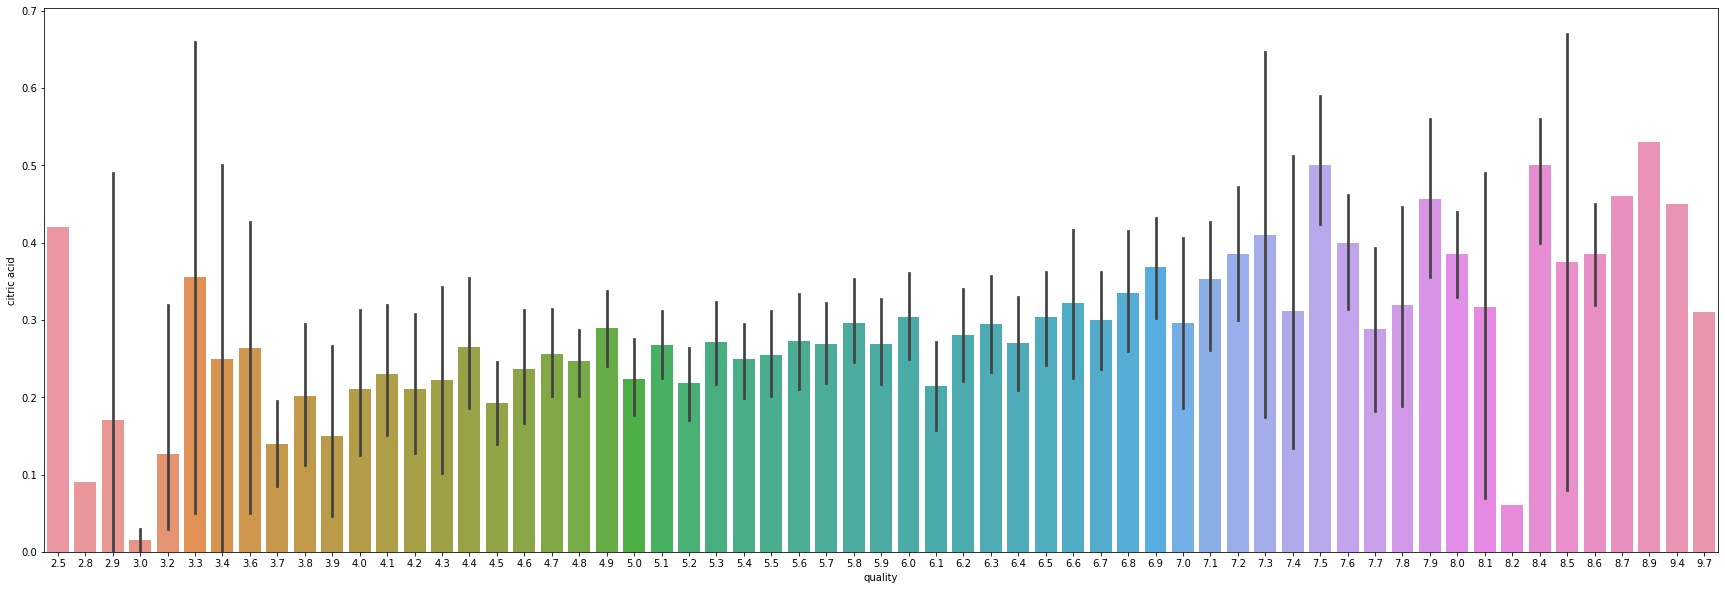

In [17]:
    # compare citric acid and quality try to find relationship
    plot = plt.figure(figsize=(30,10))
    sns.barplot(x='quality', y ='citric acid', data = wine)

In [18]:
# correlation for all values
correlation = wine.corr()

<AxesSubplot:>

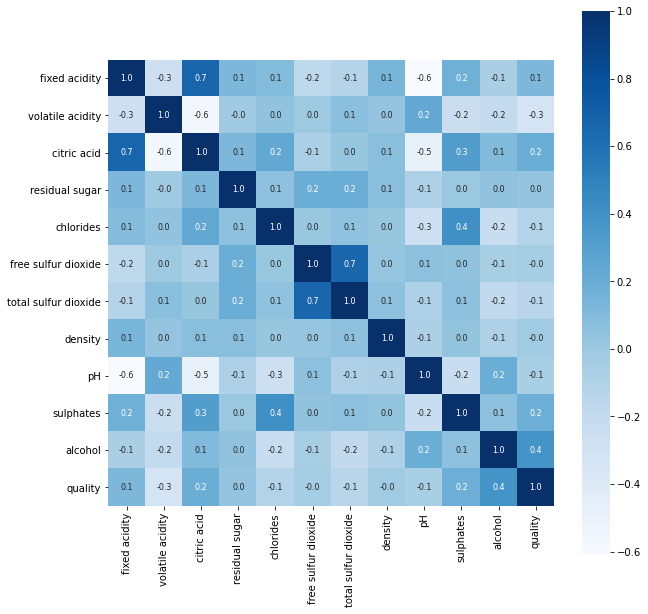

In [19]:
# constructing a heatmap to understand
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8},cmap='Blues')

In [20]:
#data prepocess
#separate the data and label
X = wine.drop('quality',axis = 1)

In [21]:
print(X)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               9.8              0.63         0.24             2.4      0.078   
1               6.1              0.34         0.25             1.8      0.084   
2               7.1              0.43         0.17             1.8      0.083   
3               8.6              0.47         0.27             1.9      0.058   
4               6.9              0.41         0.30             8.9      0.084   
...             ...               ...          ...             ...        ...   
1275            7.6              0.54         0.21             2.2      0.071   
1276            7.1              0.65         0.00             3.9      0.086   
1277            9.4              0.34         0.37             2.2      0.074   
1278            9.6              0.73         0.10             2.1      0.080   
1279           10.6              0.68         0.22             2.7      0.107   

      free sulfur dioxide  

In [22]:
Y = wine['quality'].apply(lambda y_value:1 if y_value >=7 else 0)
print(Y)


0       0
1       0
2       0
3       0
4       0
       ..
1275    0
1276    0
1277    0
1278    0
1279    0
Name: quality, Length: 1280, dtype: int64


In [23]:
# tain & test split
X_train, X_test, Y_train, Y_test =  train_test_split(X,Y, test_size=0.2,random_state=2 )

In [24]:
print(Y.shape,Y_train.shape,Y_test.shape)

(1280,) (1024,) (256,)


In [12]:
# 精度向上ポイント: バッチサイズの大小
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE)

# ニューラルネットの定義
# 精度向上ポイント: 中間層の数・ユニット数の大小、活性化関数の選択
# 精度向上ポイント（発展）: ドロップアウト層・バッチノーマリゼーションの使用
class MLP(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.layer_1 = nn.Linear(num_features, 128)  # 入力層
        self.layer_2 = nn.Linear(128, 128)  # 中間層
        self.layer_3 = nn.Linear(128, 64)  # 中間層
        self.layer_out = nn.Linear(64, 1)  # 出力層
        
        
        self.dropout1 = nn.Dropout(p=0.7)
        self.dropout2 = nn.Dropout(p=0.6)
        self.dropout3 = nn.Dropout(p=0.6)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
#         x = self.layer_1(inputs)
#         x = self.batchnorm1(x)
#         x = F.relu(x)
#         x = self.dropout(x)
        
#         x = self.layer_2(x)
#         x = self.batchnorm2(x)
#         x = F.relu(x)
#         x = self.dropout(x)
        
#         x = self.layer_3(x)
#         x = nn.Linear(x)
#         x = self.batchnorm3(x)
#         x = self.dropout(x)
        
#         x = self.layer_out(x)
        
        x = F.relu(self.dropout1(self.batchnorm1(self.layer_1(inputs))))
#         x = self.dropout1(x)
        
        x = F.relu(self.dropout2(self.batchnorm2(self.layer_2(x))))
#         x = self.dropout2(x)
        
        x = F.relu(self.dropout3(self.batchnorm3(self.layer_3(x))))
#         x = self.dropout3(x)
        
        x = self.layer_out(x)
        return x

print(MLP)

NUM_FEATURES = 11
mlp = MLP(NUM_FEATURES)
mlp.to(DEVICE)


<class '__main__.MLP'>


MLP(
  (layer_1): Linear(in_features=11, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (dropout2): Dropout(p=0.6, inplace=False)
  (dropout3): Dropout(p=0.6, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Epoch 001: | Train Loss: 28.14432 | Val Loss: 26.09948

 lambda1 learning rate  0.001
Epoch 002: | Train Loss: 20.33450 | Val Loss: 21.27722

 lambda1 learning rate  0.001
Epoch 003: | Train Loss: 14.40563 | Val Loss: 16.44754

 lambda1 learning rate  0.001
Epoch 004: | Train Loss: 9.65807 | Val Loss: 12.02535

 lambda1 learning rate  0.001
Epoch 005: | Train Loss: 6.10360 | Val Loss: 7.82231

 lambda1 learning rate  0.001
Epoch 006: | Train Loss: 4.83332 | Val Loss: 4.78696

 lambda1 learning rate  0.001
Epoch 007: | Train Loss: 3.95798 | Val Loss: 3.69801

 lambda1 learning rate  0.001
Epoch 008: | Train Loss: 3.26269 | Val Loss: 3.39982

 lambda1 learning rate  0.001
Epoch 009: | Train Loss: 3.35015 | Val Loss: 2.66620

 lambda1 learning rate  0.001
Epoch 010: | Train Loss: 3.17980 | Val Loss: 2.42443

 lambda1 learning rate  0.001
Epoch 011: | Train Loss: 3.11180 | Val Loss: 2.69729

 lambda1 learning rate  0.001
Epoch 012: | Train Loss: 3.19353 | Val Loss: 2.51910

 lambda1 learni

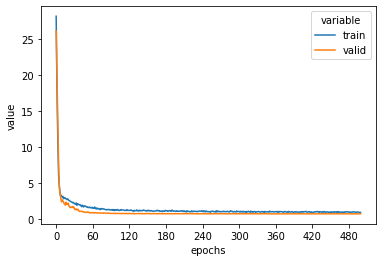

In [13]:
    # 損失関数の定義
    loss_fn = nn.MSELoss()

    # オプティマイザの定義
    # 精度向上ポイント: 学習率の選択、オプティマイザの選択
    # 精度向上ポイント（発展）: weight decayの大小、スケジューラの使用
    LEARNING_RATE = 0.001
    optimizer = torch.optim.Adam(mlp.parameters(), lr=LEARNING_RATE,weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.7)

    # 学習の実行
    # 精度向上ポイント: エポック数の大小
    NUM_EPOCHS = 500
    loss_stats = {'train': [], 'valid': []}
    for e in range(1, NUM_EPOCHS+1):

        # 訓練
        train_epoch_loss = 0
        mlp.train()
        for x, t in train_loader:
            x, t = x.to(DEVICE), t.unsqueeze(1).to(DEVICE)
            optimizer.zero_grad()  # 勾配の初期化
            pred = mlp(x)  # 予測の計算(順伝播)
            loss = loss_fn(pred, t)  # 損失関数の計算
            loss.backward()  # 勾配の計算（逆伝播）
            optimizer.step()  # 重みの更新
            train_epoch_loss += loss.item()
        scheduler.step()
    # 検証  
    with torch.no_grad():
        valid_epoch_loss = 0
        mlp.eval()
        for x, t in valid_loader:
            x, t = x.to(DEVICE), t.unsqueeze(1).to(DEVICE)
            pred = mlp(x)  # 予測の計算(順伝播)
            loss = loss_fn(pred, t)  # 損失関数の計算
            valid_epoch_loss += loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['valid'].append(valid_epoch_loss/len(valid_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} \
| Val Loss: {valid_epoch_loss/len(valid_loader):.5f}')
    print('\n lambda1 learning rate ',optimizer.param_groups[0]['lr'])

# 学習曲線の描画
df_loss = pd.DataFrame.from_dict(loss_stats).reset_index()
df_loss = df_loss.melt(id_vars=['index']).rename(columns={"index": "epochs"})
sns.lineplot(data=df_loss, x="epochs", y="value", hue="variable")
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))


# 推論の実行
mlp.eval()
preds = []
for x in test_loader:
    x = x.to(DEVICE)
    pred = mlp(x)
    pred = pred.squeeze()
    preds.extend(pred.tolist())

submission = pd.Series(preds, name='quality')
submission.to_csv('/root/userspace/submission1_pred.csv', 
                  header=True, index_label='id')